(1201, 3001, 3)


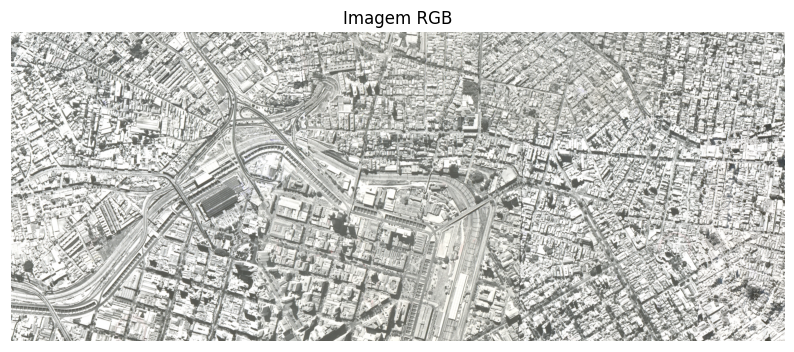

In [3]:
import pystac
from pystac_client import Client
import odc.stac
import numpy as np
import matplotlib.pyplot as plt

# Conectar ao catálogo STAC
catalog_url = "http://localhost:8001/stac"
client = Client.open(catalog_url)

# Buscar itens no catálogo
search = client.search(
    collections="bh_ortophoto",  # Nome da coleção
    bbox=[-43.941925, -19.917622, -43.930232, -19.908802],  # Bounding box
    datetime="1993-01-01/2003-12-31"  # Intervalo de tempo
)

# Obter a coleção de itens
items = search.item_collection()

# Corrigir os metadados de projeção
for item in items:
    for asset_key, asset in item.assets.items():
        if "proj:code" in asset.extra_fields:
            asset.extra_fields["proj:epsg"] = int(asset.extra_fields["proj:code"].split(":")[1])  # Extrai o código EPSG

# Carregar os dados como um cubo
xx = odc.stac.load(
    items,
    bands=["red", "green", "blue"],  # Bandas espectrais
    crs="EPSG:31983",  # Especificar o CRS
    resolution=1.0,  # Especificar a resolução
)

# Selecionar as bandas RGB
red = xx["red"]
green = xx["green"]
blue = xx["blue"]

# Normalizar as bandas para o intervalo [0, 1]
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())

# Combinar as bandas em uma imagem RGB
rgb_image = np.stack([red_normalized, green_normalized, blue_normalized], axis=-1)

# Remover a dimensão extra (se houver)
rgb_image = rgb_image.squeeze(axis=0)  # Remove a primeira dimensão

# Verificar a forma da imagem
print(rgb_image.shape)  # Deve ser (height, width, 3)

# Plotar a imagem RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis("off")  # Remover eixos
plt.title("Imagem RGB")
plt.show()